In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

In [20]:
df = pd.read_csv("./train.csv", index_col=0)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['store_nbr', 'family', 'date']).reset_index(drop=True)
df.head()

,date,store_nbr,family,sales,cluster,is_holiday,oil_price
0,2013-01-02,1,AUTOMOTIVE,2.0,13,0,93.14
1,2013-01-03,1,AUTOMOTIVE,3.0,13,0,92.97
2,2013-01-04,1,AUTOMOTIVE,3.0,13,0,93.12
3,2013-01-07,1,AUTOMOTIVE,0.0,13,0,93.20
4,2013-01-08,1,AUTOMOTIVE,2.0,13,0,93.21


In [ ]:
def ohe(df, categorical_columns):
  encoder = OneHotEncoder(sparse_output=False)

  one_hot_encoded = encoder.fit_transform(df[categorical_columns])

  new_columns = encoder.get_feature_names_out(categorical_columns)
  one_hot_df = pd.DataFrame(one_hot_encoded,
                            columns=new_columns)

  return new_columns, pd.concat([df, one_hot_df], axis=1)


# static_cat_cols, df = ohe(df,  ['store_nbr', 'family', 'cluster'])
static_cat_cols, df = ohe(df,  ['family', 'cluster'])


In [22]:
dynamic_num_cols = ['sales', 'oil_price']
scalers = {}
for col in dynamic_num_cols:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

dynamic_num_cols.append("is_holiday")


In [23]:
def encode_dates(df, date_column):
    dates = df[date_column]

    df['year'] = dates.dt.year -2013
    df['day_of_year_sin'] = np.sin(2 * np.pi * dates.dt.dayofyear / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * dates.dt.dayofyear / 365)
    df['day_of_month_sin'] = np.sin(2 * np.pi * dates.dt.day / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * dates.dt.day / 31)
    df['day_of_week_sin'] = np.sin(2 * np.pi * dates.dt.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * dates.dt.dayofweek / 7)
    df['month_sin'] = np.sin(2 * np.pi * dates.dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * dates.dt.month / 12)


encode_dates(df, "date")

dynamic_num_cols.extend([
    'year',
    'day_of_year_sin',
    'day_of_year_cos',
    'day_of_month_sin',
    'day_of_month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
])


In [24]:
static_cat_cols = list(static_cat_cols)

In [25]:
SEQUENCE_LENGTH = 4

def create_sequences(data, seq_length=SEQUENCE_LENGTH, dynamic_cols=dynamic_num_cols, static_cols=static_cat_cols, target_col='sales'):
    sequences = []
    targets = []
    static_features_for_target = []

    # entity_cols = ['store_nbr', 'family', "cluster"] # Core entity identifiers
    entity_cols = ['family', "cluster"] # Core entity identifiers

    for _, group in data.groupby(entity_cols):
        group_dynamic_data = group[dynamic_cols].values
        group_static_data_at_target = group[static_cols + [target_col]].values # Static features + target sales

        for i in range(len(group) - seq_length):
            seq = group_dynamic_data[i : i + seq_length]
            sequences.append(seq)

            target_val = group_static_data_at_target[i + seq_length, -1] # Last col is target_col ('sales')
            targets.append(target_val)

            static_vals = group_static_data_at_target[i + seq_length, :-1]
            static_features_for_target.append(static_vals)

    return (np.array(sequences),
            np.array(static_features_for_target),
            np.array(targets).reshape(-1, 1))

X_dynamic, X_static, y = create_sequences(df, SEQUENCE_LENGTH)

print(f"X_dynamic shape: {X_dynamic.shape}")
print(f"X_static shape: {X_static.shape}")
print(f"y shape: {y.shape}")


X_dynamic shape: (2096952, 4, 12)
X_static shape: (2096952, 50)
y shape: (2096952, 1)


In [26]:
limit = 100000
if limit != 0:
  X_dynamic = X_dynamic[-limit:, :, :]
  X_static = X_static[-limit:, :]
  y = y[-limit:]

print(f"X_dynamic shape: {X_dynamic.shape}")
print(f"X_static shape: {X_static.shape}")
print(f"y shape: {y.shape}")

X_dynamic shape: (100000, 4, 12)
X_static shape: (100000, 50)
y shape: (100000, 1)


In [27]:
(X_dynamic_train, X_dynamic_val,
 X_static_train, X_static_val,
 y_train, y_val) = train_test_split(X_dynamic, X_static, y, test_size=0.2, random_state=42)

In [28]:
BATCH_SIZE = 64

class SalesDataset(Dataset):
    def __init__(self, dynamic_features, static_features, targets):
        self.dynamic_features = torch.tensor(dynamic_features, dtype=torch.float32)
        self.static_features = torch.tensor(static_features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (self.dynamic_features[idx],
                self.static_features[idx],
                self.targets[idx])

train_dataset = SalesDataset(X_dynamic_train, X_static_train, y_train)
val_dataset = SalesDataset(X_dynamic_val, X_static_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
HIDDEN_SIZE_LSTM = 64
HIDDEN_SIZE_FC = 32

class SalesPredictorLSTM(nn.Module):
    def __init__(self, num_dynamic_features,
                 lstm_hidden_size, fc_hidden_size, num_static_features):
        super().__init__()
        self.num_static_features = num_static_features

        self.static_dim = 16

        self.static_mlp = nn.Sequential(
            nn.Linear(num_static_features, 64),
            nn.ReLU(),
            nn.Linear(64, self.static_dim),
            nn.ReLU(),

        )

        # LSTM for dynamic features
        self.lstm = nn.LSTM(input_size=num_dynamic_features,
                            hidden_size=lstm_hidden_size,
                            batch_first=True,
                            num_layers=1)


        self.fc1 = nn.Linear(lstm_hidden_size + self.static_dim , fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)

    def forward(self, dynamic_seq, static_feats):
        # dynamic_seq: (batch, seq_len, num_dynamic_features)
        # static_feats: (batch, num_static_features)

        # LSTM part
        lstm_out, (h_n, c_n) = self.lstm(dynamic_seq)
        lstm_last_hidden = h_n[-1]

        # Static part
        static_features = self.static_mlp(static_feats)

        # Combine LSTM output and embeddings
        combined = torch.cat((lstm_last_hidden, static_features), dim=1)

        # Pass through FC layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.fc2(x)
        return self.relu(x)


model = SalesPredictorLSTM(
    num_dynamic_features=X_dynamic_train.shape[2],
    lstm_hidden_size=HIDDEN_SIZE_LSTM,
    fc_hidden_size=HIDDEN_SIZE_FC,
    num_static_features=X_static_train.shape[1]
).to(DEVICE)

print("\nModel Architecture:")
print(model)



Model Architecture:
SalesPredictorLSTM(
  (static_mlp): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (lstm): LSTM(12, 64, batch_first=True)
  (fc1): Linear(in_features=80, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [30]:
EPOCHS = 10
LEARNING_RATE = 5e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss_epoch = 0
    for dynamic_batch, static_batch, target_batch in tqdm(train_loader):
        dynamic_batch, static_batch, target_batch = \
            dynamic_batch.to(DEVICE), static_batch.to(DEVICE), target_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(dynamic_batch, static_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

    train_loss_epoch /= len(train_loader)

    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for dynamic_batch, static_batch, target_batch in tqdm(val_loader):
            dynamic_batch, static_batch, target_batch = \
                dynamic_batch.to(DEVICE), static_batch.to(DEVICE), target_batch.to(DEVICE)
            outputs = model(dynamic_batch, static_batch)
            loss = criterion(outputs, target_batch)
            val_loss_epoch += loss.item()
    val_loss_epoch /= len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss_epoch:.6f}, Val Loss: {val_loss_epoch:.6f}")




Starting Training...


100%|██████████| 313/313 [00:00<00:00, 486.33it/s]


Epoch 1/10, Train Loss: 0.000098, Val Loss: 0.000057


100%|██████████| 313/313 [00:00<00:00, 762.68it/s]


Epoch 2/10, Train Loss: 0.000048, Val Loss: 0.000037


100%|██████████| 313/313 [00:00<00:00, 771.28it/s]


Epoch 3/10, Train Loss: 0.000040, Val Loss: 0.000035


100%|██████████| 313/313 [00:00<00:00, 735.39it/s]


Epoch 4/10, Train Loss: 0.000036, Val Loss: 0.000046


100%|██████████| 313/313 [00:00<00:00, 777.96it/s]


Epoch 5/10, Train Loss: 0.000034, Val Loss: 0.000034


100%|██████████| 313/313 [00:00<00:00, 506.18it/s]


Epoch 6/10, Train Loss: 0.000032, Val Loss: 0.000031


100%|██████████| 313/313 [00:00<00:00, 745.43it/s]


Epoch 7/10, Train Loss: 0.000030, Val Loss: 0.000032


100%|██████████| 313/313 [00:00<00:00, 744.18it/s]


Epoch 8/10, Train Loss: 0.000030, Val Loss: 0.000028


100%|██████████| 313/313 [00:00<00:00, 760.86it/s]


Epoch 9/10, Train Loss: 0.000029, Val Loss: 0.000026


100%|██████████| 313/313 [00:00<00:00, 761.72it/s]

Epoch 10/10, Train Loss: 0.000028, Val Loss: 0.000038


In [ ]:
predictions = []
actuals =[]

model.eval()
with torch.no_grad():
    for i in tqdm(range(len(val_dataset))):
      sample_dynamic, sample_static, sample_target = val_dataset[i]
      sample_dynamic = sample_dynamic.unsqueeze(0).to(DEVICE)
      sample_static = sample_static.unsqueeze(0).to(DEVICE)

      prediction_scaled = model(sample_dynamic, sample_static)

      prediction_original_scale = scalers['sales'].inverse_transform(prediction_scaled.cpu().numpy())
      target_original_scale = scalers['sales'].inverse_transform(sample_target.cpu().numpy().reshape(-1,1))

      predictions.append(prediction_original_scale[0][0])
      actuals.append(target_original_scale[0][0])


100%|██████████| 20000/20000 [00:20<00:00, 979.71it/s] 


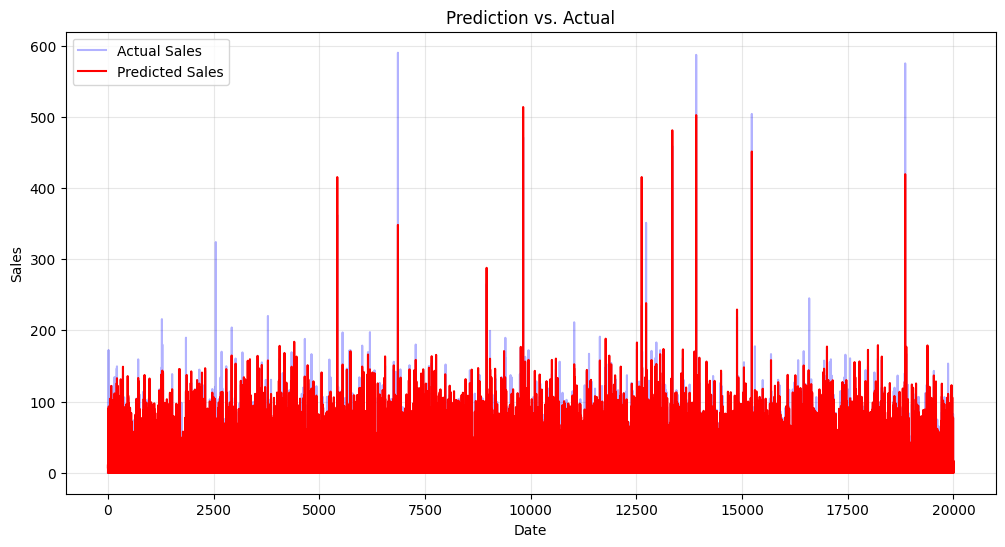

In [32]:
import matplotlib.pyplot as plt

# Plot predictions vs. actuals
plt.figure(figsize=(12, 6))
indices = list(range(len(actuals)))
plt.plot(indices, actuals, label='Actual Sales', alpha=0.3, color='blue')
plt.plot(indices, predictions, label='Predicted Sales', color='red', linestyle='-')
plt.title("Prediction vs. Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [33]:

# torch.save(model.state_dict(), 'sales_predictor_lstm.pth')
# To load:
# model_loaded = SalesPredictorLSTM(...)
# model_loaded.load_state_dict(torch.load('sales_predictor_lstm.pth'))
# model_loaded.to(DEVICE)
# model_loaded.eval()